In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch

### Check if PyTorch recognizes GPU

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Create function to extract frames from a video file

In [15]:
# https://docs.opencv.org/4.x/d8/dfe/classcv_1_1VideoCapture.html

def frame_extract(filepath, max_frames, frame_size):
    frames = []

    # begin reading from video
    capture = cv2.VideoCapture(filepath)
    if not capture.isOpened():
        print("Cannot open file")
        exit()
    while True:
        retval, image = capture.read()
        if not retval:
            break
        image = cv2.resize(image, frame_size)
        frames.append(image)

    # stop reading from video
    capture.release()

    # pad video by repeating animation until all samples are of equal length Holding -> 209
    # Pad video by repeating frames cyclically if it's shorter than max_frames
    while len(frames) < max_frames:
        num_padded = max_frames - len(frames)
        repeat_frames = frames[:num_padded]  # Repeat from the start
        frames.extend(repeat_frames)

    return np.array(frames)


#### Verify that the correct amount of frames are extracted

In [16]:
filename = 'Pointing_Day_Plain_front_30fps.mkv'
test_filepath = './dataset/Pointing/Day/Plain/' + filename
max_frames = 210 # longest animation is Holding_Something_In_Pain at 209 frames
frame_size = (416, 416)
test_frames = frame_extract(test_filepath, max_frames, frame_size)
print(len(test_frames)) # should be 210 total

210


#### Display example frames from image sequence

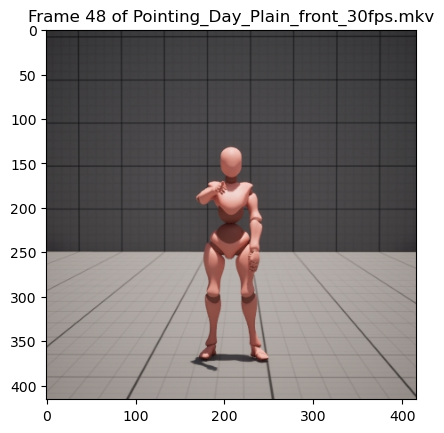

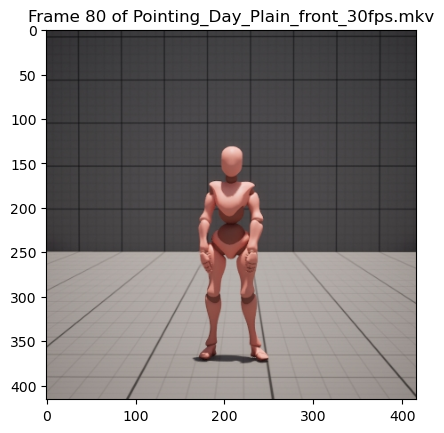

In [17]:
ex_frame1 = 48
example_frame = cv2.cvtColor(test_frames[ex_frame1], cv2.COLOR_BGR2RGB)

plt.imshow(example_frame)
plt.title(f'Frame {ex_frame1} of {filename}')
plt.show()

ex_frame2 = 80
example_frame2 = cv2.cvtColor(test_frames[ex_frame2], cv2.COLOR_BGR2RGB)
plt.imshow(example_frame2)
plt.title(f'Frame {ex_frame2} of {filename}')
plt.show()

### Define dataset with PyTorch

In [18]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
from torch.utils.data import Dataset

class DistressActionDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.labels = []
        self.data = []
        self.transform = transform

        # add all mp4's to 'videos', and appropriate label (as filepaths) to 'labels'
        # Labels: Holding_Something_In_Pain, Injured_Walk, Jumping, Pointing, Running, Waving
        for label_folder in os.listdir(root):
            label_filepath = os.path.join(root, label_folder)
            # Times: Day, Night
            for time_folder in os.listdir(label_filepath):
                time_filepath = os.path.join(label_filepath, time_folder)
                # Environments: Rural, Plain, Grassy
                for env_folder in os.listdir(time_filepath):
                    env_filepath = os.path.join(time_filepath, env_folder)
                    # Direction: Right, Left, Front, Back
                    for video in os.listdir(env_filepath):
                        if video.endswith(".mkv"):
                            video_file = os.path.join(env_filepath, video)
                            self.data.append(video_file)
                            self.labels.append(label_folder)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path = self.data[idx]
        label = self.labels[idx]

        frames = frame_extract(video_path, max_frames, frame_size)

        # put frames on tensor in (frames, channels, height, width) order
        # normalize pixel values
        frames = torch.from_numpy(frames).permute(0, 3, 1, 2).float() / 255.0
        # Apply transform to all frames in video
        if self.transform:
            for i in range(len(frames)):
                frames[i] = self.transform(frames[i])
        
        return frames, label

## Define Model using PyTorch

In [19]:
import torch.nn as nn
import torch.nn.functional as F
# pretrained CNN models - https://pytorch.org/vision/0.9/models.html
from torchvision.models import resnet34

class DistressClassifier(nn.Module):
    def __init__(self, classes=6):
        super().__init__()
        self.resnet = resnet34(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 180))

        for param in self.resnet.fc.parameters():
            param.requires_grad = True
            
        # TODO: can stack multiple LSTM cells with 'num_layers' arg
        self.lstm = nn.LSTM(input_size=180, hidden_size=144)
        self.fc1 = nn.Linear(144, 64)
        self.fc2 = nn.Linear(64, classes)
    
    def forward(self, x):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x.size(1)):
            with torch.no_grad():
                resnet_x = self.resnet(x[:, t])  
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(resnet_x.unsqueeze(0), hidden)         

        # Get the last hidden state
        resnet_x = self.fc1(hidden[0][-1])
        resnet_x = F.relu(resnet_x)
        resnet_x = self.fc2(resnet_x)

        return resnet_x

#### Define Transforms

In [20]:
from torchvision.transforms import v2

augment = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.GaussianNoise()
])

### Segment Dataset into Training and Test portions.

In [21]:
from torch.utils.data import random_split
dataset_path = './dataset'
dataset = DistressActionDataset(dataset_path, augment)
# 80% of dataset set aside for training, 20% for test
train_len = int(len(dataset)*0.8)      
train_set, test_set = random_split(dataset, [train_len, len(dataset)-train_len])

### Define DataLoader, Optimizer, Loss Function, and Model

In [22]:
import torch.optim
from torch.utils.data import DataLoader

model = DistressClassifier()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

### Create Training Loop

In [ ]:
# This training loop is modified from https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

def train_model(model, train_loader, optimizer, loss_fn, epoch_count):
    for epoch_index in range(epoch_count):
        print(f"Epoch {epoch_index + 1}/{epoch_count}")
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            # get sample, move to device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero gradients
            optimizer.zero_grad()

            # make predictions for batch
            outputs = model(inputs)

            # compute loss and gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            # adjust learning weights
            optimizer.step()

            # gather training data and print periodically
            running_loss += loss.item()
        
            print(f"  Batch {i + 1} loss: {running_loss:.4f}")
            running_loss = 0.0

        print(f"Epoch {epoch_index + 1} complete. Last batch loss: {running_loss:.4f}")

### Train Model

In [24]:
epochs = 3
train_model(model, train_dataloader, optimizer, loss_fn, epochs)

Epoch 1/3


KeyboardInterrupt: 